In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import math

def evaluate_traj_length(traj):
    if traj is None:
        return 10.0
    path_length = 0
    for idx in range(1, traj.size // 2):
        path_length += math.pow(
            math.pow(traj[idx , 0] - traj[idx - 1 , 0], 2) + math.pow(traj[idx, 1] - traj[idx - 1, 1], 2),
            0.5
        )
    return path_length

def evaluate_env_free_space(env):
    return 100 * np.count_nonzero((env.arena.occ_grid == 0) == True) / env.arena.occ_grid.size

def evaluate_num_of_obstacles(env):
    obstacle_count = 0
    grid = env.arena.occ_grid
    for row_idx in range(len(grid)):

        for col_idx in range(len(grid[row_idx])):
            if grid[row_idx, col_idx] == 1:
                locs_to_check = np.array(
                    np.meshgrid(
                        np.array([row_idx - 1, row_idx, row_idx + 1]),
                        np.array([col_idx - 1, col_idx, col_idx + 1])
                    )).T.reshape(-1,2)
                for location in locs_to_check:
                    if location[0] < 0 \
                        or location[0] > len(grid) - 1 \
                        or location[1] < 0 \
                        or location[1] > len(grid[row_idx]) - 1 \
                        or (location[0], location[1]) == (row_idx, col_idx):
                            continue
                    if grid[location[0], location[1]] != 1:
                        obstacle_count += 1
    return obstacle_count

In [3]:
from environment import RBF2dGymEnv
from controller import RRTController
from kernel import RRTKernelNormal, RBF2dEnvKernelNormal

def evaluate(model_params, plot_sol=False):
    env = RBF2dGymEnv(
        use_lidar=False,
        N_points=int(model_params[0]),
        threshold=model_params[1],
        rbf_gamma=model_params[2],
        obs_low=-0.7,
        obs_high=0.7,
        grid_res=150,
        grid_bd=1.2,
        seed=1337
    )
    start = [-1, -1]
    end = [1, 1]
    controller = RRTController()
    controller_kernel = RRTKernelNormal(start, end)
    env_kernel = RBF2dEnvKernelNormal()
    env_kernel.sample_prior()
    controller_kernel.sample_prior()
    try:
        env.reset(env_kernel.value)
    except AssertionError:
        # print("Invalid config", model_params)
        pass
    traj = controller.get_trajectory(env, controller_kernel)
    if plot_sol:
        plt.imshow(env.arena.occ_grid, origin='lower', extent=[-1.2, 1.2, -1.2, 1.2], cmap='gray_r', vmin=0, vmax=2)
        if traj is not None:
            plt.plot(traj[:, 0], traj[:, 1])
        plt.show()
    return evaluate_traj_length(traj), evaluate_env_free_space(env), evaluate_num_of_obstacles(env)

In [4]:
from ribs.archives import GridArchive

archive = GridArchive(
    [100, 10],
    [(0.0, 100.0), (0, 100)]
)

In [5]:
from ribs.emitters import GaussianEmitter

emitters = [
    GaussianEmitter(
        archive,
        np.array([10, 1.0, 30]),
        1.0,
        batch_size=25,
    ) for _ in range(5)
]

In [6]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

In [7]:
import time

from tqdm import tqdm

start_time = time.time()
total_itrs = 10

for itr in tqdm(range(1, total_itrs + 1)):
    sols = optimizer.ask()

    objs, bcs = [], []
    for model in sols:
        obj, percent_empty, num_of_obstacles = evaluate(model)
        objs.append(obj)
        bcs.append([percent_empty, num_of_obstacles])

    optimizer.tell(objs, bcs)

    if itr % 25 == 0:
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time:.2f} s")
        print(f"  - Archive Size: {len(archive)}")
        print(f"  - Max Score: {archive.stats.obj_max}")


100%|██████████| 10/10 [05:37<00:00, 33.76s/it]


Text(0.5, 0, 'Percentage of free space')

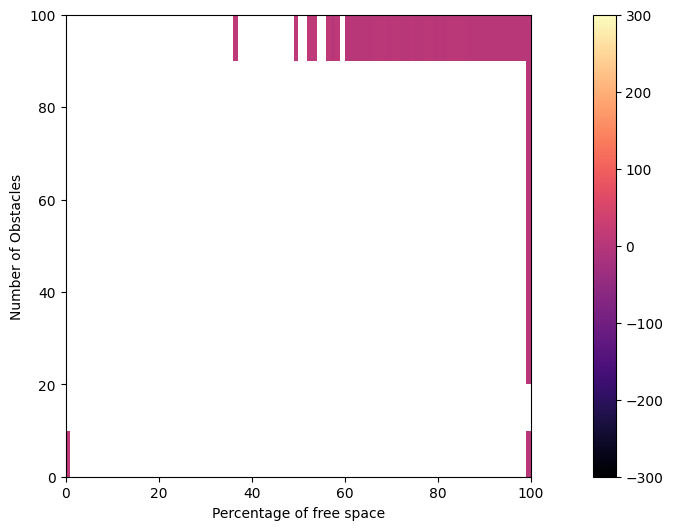

In [8]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.ylabel("Number of Obstacles")
plt.xlabel("Percentage of free space")

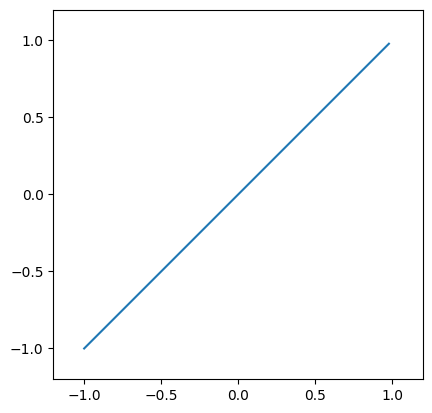

Elite(sol=array([ 9.85777881,  2.32234366, 28.74948464]), obj=2.798654207643597, beh=array([100.,   0.]), idx=(99, 0), meta=None)


In [10]:
elite = archive.elite_with_behavior([100, 0])
evaluate(elite.sol, True)
print(elite)

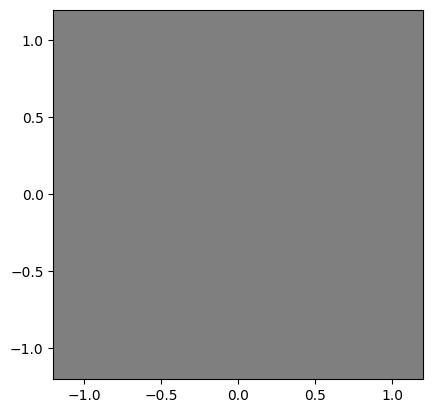

Elite(sol=array([11.29800106, -0.44684667, 30.21365461]), obj=10.0, beh=array([0., 0.]), idx=(0, 0), meta=None)


In [13]:
elite = archive.elite_with_behavior([0, 0])
evaluate(elite.sol, True)
print(elite)

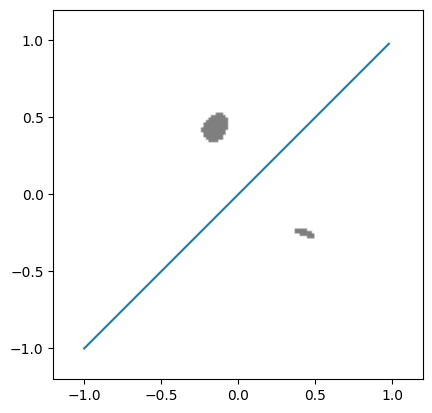

Elite(sol=array([ 9.64229657,  1.98387823, 29.84277771]), obj=2.798654207643597, beh=array([ 99.48444444, 168.        ]), idx=(99, 9), meta=None)


In [20]:
elite = archive.elite_with_behavior([100, 100])
evaluate(elite.sol, True)
print(elite)